In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
import requests
from bs4 import BeautifulSoup


In [47]:
df = pd.read_csv('../2_clean_data/final_combine_data.csv')

In [48]:
#Columns with lists are represented as strings, so this is converting them into list/np.array types

for index, row in df.iterrows():
    df.iloc[index]['salaries'] = ast.literal_eval(df.iloc[index]['salaries'])
    df.iloc[index]['semester'] = ast.literal_eval(df.iloc[index]['semester'])
    df.iloc[index]['years_taught'] = ast.literal_eval(df.iloc[index]['years_taught'])
    df.iloc[index]['course'] = ast.literal_eval(df.iloc[index]['course'])
    df.iloc[index]['average_rating'] = np.fromstring(df.iloc[index]['average_rating'].strip("[]"), sep=',')
    df.iloc[index]['num_reviews'] = np.fromstring(df.iloc[index]['num_reviews'].strip("[]"), sep=',')
    df.iloc[index]['average_gpa'] = np.fromstring(df.iloc[index]['average_gpa'].strip("[]"), sep=',')
    df.iloc[index]['num_students'] = ast.literal_eval(df.iloc[index]['num_students'])
    


#json.loads(df.iloc[0]['salaries'])[0]

In [34]:
count = 0
for index, row in df.iterrows():
    if all(len(x) == len(row['course']) for x in [row['semester'], row['average_rating'], row['num_reviews'], row['average_gpa'], row['num_students']]):
        pass
    else:
        display(df.iloc[index])
        print("index is", index)

name                                                       MIN WANG
course            [EDHD320, EDHD425, EDHD425, EDHD425, EDHD320, ...
semester          [spring 2021, spring 2010, fall 2012, winter 2...
average_rating    [5.0, 3.0, 3.0, 2.0, nan, nan, nan, nan, nan, ...
num_reviews       [1.0, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan, ...
average_gpa       [3.51, nan, 3.23, nan, 3.55, 4.0, 3.29, 3.77, ...
num_students      [82, 0, 68, 0, 37, 33, 39, 37, 38, 6, 21, 50, ...
years_taught      [2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...
salaries          [77524.08, 88736.8, 103327.84, 103327.84, 1057...
departments       ['EDUC', 'EDUC', 'EDUC', 'EDUC', 'EDUC', 'EDUC...
real_name(s)                                              Wang, Min
_merge                                                         both
Name: 1615, dtype: object

index is 1615


name                                                    MIN QI WANG
course            [HLTH652, HLTH652, HLTH652, HLTH652, HLTH652, ...
semester          [fall 2020, fall 2022, fall 2014, spring 2016,...
average_rating        [nan, nan, nan, nan, nan, nan, nan, nan, nan]
num_reviews           [nan, nan, nan, nan, nan, nan, nan, nan, nan]
average_gpa       [3.81, 3.55, 3.68, 3.85, 3.81, 3.6, 4.0, 3.89,...
num_students                         [8, 10, 6, 8, 10, 8, 5, 8, 15]
years_taught      [2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...
salaries          [102630.38, 106709.29, 110883.47, 110883.47, 1...
departments       ['SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL', 'SPHL...
real_name(s)                                           Wang, Min Qi
_merge                                                         both
Name: 1616, dtype: object

index is 1616


In [57]:
#Drop all rows where the array lengths of course, semester, average_rating, num_reviews, average_gpa, num_students are not equal
#Only applies to Min Wang and Min Qi Wang (rows 1615 and 1616)

df = df.drop([1615, 1616], axis=0)

In [ ]:
display(df.iloc[1615]['course'])
display(df.iloc[1615]['semester'])

print(len(df.iloc[1615]['course']))
print(len(df.iloc[1615]['semester']))
print(len(df.iloc[1615]['average_rating']))
print(len(df.iloc[1615]['num_reviews']))
print(len(df.iloc[1615]['average_gpa']))
print(len(df.iloc[1615]['num_students']))

['EDHD320',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD320',
 'EDHD320',
 'EDHD320',
 'EDHD320',
 'EDHD420',
 'EDHD420',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD425',
 'EDHD460',
 'EDHD460']

['spring 2021',
 'spring 2010',
 'fall 2012',
 'winter 2013',
 'fall 2020',
 'spring 2020',
 'fall 2021',
 'fall 2022',
 'spring 2012',
 'spring 2014',
 'spring 2012',
 'fall 2013',
 'spring 2013',
 'fall 2014',
 'fall 2016',
 'spring 2016',
 'fall 2017',
 'spring 2017',
 'fall 2018',
 'spring 2018',
 'fall 2019',
 'spring 2019',
 'fall 2020',
 'spring 2020',
 'fall 2021',
 'fall 2022',
 'spring 2017',
 'spring 2019',
 'fall 2012',
 'fall 2015',
 'fall 2016',
 'fall 2018']

28
32
32
32
32
32


In [58]:
df = df.explode(['course', 'semester', 'average_rating', 'num_reviews', 'average_gpa', 'num_students'])

In [28]:
for index, row in df.iterrows():
    # if len(row['course']) * 6 != len(row['course']) + len(row['semester']) + len(row['average_rating']) + len(row['num_reviews']) + len(row['average_gpa']) + len(row['num_students']):
    #     print('in here')
    
    # for x in zip(row['course'], row['semester'], row['average_rating'], row['num_reviews'], row['average_gpa'], row['num_students']):
    #     print(list(x))
    # print('done')
    
    if len(row['salaries']) * 3 == len(row['years_taught']) + len(row['salaries']) + len(row['departments']):
        print('in here')
        


In [35]:
#Create column storing combined course data and salary data

#order for combined_course_info is [course, semester, average_rating, num_reviews, average_gpa,
# num_students]]

df['combined_salary_info'] = np.empty((len(df), 0)).tolist()

for index, row in df.iterrows():
#     for i in range(len(row['course'])):
#         df.iloc[index]['combined_course_info'].extend([list(x) for x in zip(row['course'], row['semester'], row['average_rating'], row['num_reviews'], row['average_gpa'], row['num_students'])])
    
    for i in range(len(row['salaries'])):
        df.iloc[index]['combined_salary_info'].extend([list(x) for x in zip(row['salaries'], row['years_taught'])])

In [79]:
df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)

/tmp/ipykernel_122/2949145723.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['sem', 'year']] = df['semester'].str.split(' ', 1, expand=True)


In [81]:
df['sem']

0         fall
0       spring
0       spring
0       spring
0       spring
         ...  
2696    spring
2696      fall
2696      fall
2696      fall
2696    spring
Name: sem, Length: 58301, dtype: object

In [82]:
df = df[["name", "course", "sem", "year", "average_rating", "num_reviews", "average_gpa", "num_students", "Employee", "years_taught", "salaries", "departments", "_merge", "semester"]]


In [80]:
df.head()

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,sem,year
0,A KRUGLANSKI,PSYC489H,fall 2015,2.0,1.0,NaN,0,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,fall,2015
0,A KRUGLANSKI,PSYC489H,spring 2014,NaN,NaN,3.51,16,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2014
0,A KRUGLANSKI,PSYC489H,spring 2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2015
0,A KRUGLANSKI,PSYC489T,spring 2017,NaN,NaN,3.89,17,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2017
0,A KRUGLANSKI,PSYC489T,spring 2019,NaN,NaN,3.46,20,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2019


In [73]:
df

0         fall
0       spring
0       spring
0       spring
0       spring
         ...  
2696    spring
2696      fall
2696      fall
2696      fall
2696    spring
Name: _merge, Length: 58301, dtype: object

In [71]:
df.head()

,name,course,sem,year,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,semester
0,A KRUGLANSKI,PSYC489H,fall 2015,2.0,1.0,NaN,0,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,fall,2015
0,A KRUGLANSKI,PSYC489H,spring 2014,NaN,NaN,3.51,16,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2014
0,A KRUGLANSKI,PSYC489H,spring 2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2015
0,A KRUGLANSKI,PSYC489T,spring 2017,NaN,NaN,3.89,17,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2017
0,A KRUGLANSKI,PSYC489T,spring 2019,NaN,NaN,3.46,20,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,spring,2019


In [47]:
df[df['name'] == 'AHMAD KARIMI-HAKKAK'].sort_values(by='semester')

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,combined_salary_info
32,AHMAD KARIMI-HAKKAK,PERS283,fall 2013,NaN,NaN,3.54,17,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[8949.58, 2015], [29107.38, 2016], [8949.58, ..."
32,AHMAD KARIMI-HAKKAK,PERS452,fall 2013,NaN,NaN,3.58,4,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[210000.0, 2013], [221707.5, 2014], [231361.6..."
32,AHMAD KARIMI-HAKKAK,PERS283,fall 2015,NaN,NaN,3.12,24,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[30000.0, 2017], [33000.0, 2018], [33660.0, 2..."
32,AHMAD KARIMI-HAKKAK,PERS371,fall 2015,NaN,NaN,3.11,10,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[85000.0, 2018], [86700.0, 2019], [111100.0, ..."
32,AHMAD KARIMI-HAKKAK,PERS283,fall 2016,NaN,NaN,3.56,14,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[39981.96, 2021], [41391.32, 2022], [39981.96..."
32,AHMAD KARIMI-HAKKAK,PERS371,fall 2016,NaN,NaN,3.63,7,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[95512.4, 2013], [100663.24, 2014], [105087.5..."
32,AHMAD KARIMI-HAKKAK,PERS371,spring 2011,5.0,1.0,NaN,0,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[95884.44, 2013], [95395.97, 2014], [99486.71..."
32,AHMAD KARIMI-HAKKAK,PERS302,spring 2012,NaN,NaN,3.63,19,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[27474.72, 2013], [82400.0, 2014], [85939.08,..."
32,AHMAD KARIMI-HAKKAK,PERS353,spring 2012,NaN,NaN,3.43,36,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[138020.0, 2014], [143244.07, 2015], [143244...."
32,AHMAD KARIMI-HAKKAK,PERS402,spring 2013,NaN,NaN,3.7,15,"Karimi-Hakkak, Ahmad","[2013, 2014, 2016, 2017, 2018]","[104569.03, 108327.1, 55721.12, 56037.72, 5603...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU']",both,"[[91181.59, 2013], [100293.98, 2014], [104195...."


In [45]:
#Professors that have taught in 2015

taught_in_2015 = df[df['semester'].apply(lambda x: '2015' in x)]
salaries = []

count = 0
for index, row in taught_in_2015.iterrows():
    if 2015 not in row['years_taught']:
        count +=1
        print(row)
        
#print(count)
    #salaries.append(row['salaries'][row['years_taught'].index(2015)])



name                                                          ABRAM KAGAN
course                                                            STAT410
semester                                                      spring 2015
average_rating                                                        NaN
num_reviews                                                           NaN
average_gpa                                                          3.07
num_students                                                           18
Employee                                                  Kagan, Abram M.
years_taught                                                 [2018, 2019]
salaries                                            [127678.72, 136309.8]
departments                                              ['CMNS', 'CMNS']
_merge                                                               both
combined_salary_info    [[98000.0, 2018], [99960.0, 2019], [104508.33,...
Name: 13, dtype: object
name          

In [44]:
print(len(taught_in_2015))

4241


In [37]:
taught_in_2015

,name,course,semester,average_rating,num_reviews,average_gpa,num_students,Employee,years_taught,salaries,departments,_merge,combined_salary_info
0,A KRUGLANSKI,PSYC489H,fall 2015,2.0,1.0,NaN,0,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,"[[289244.91, 2015], [289244.91, 2016], [296487..."
0,A KRUGLANSKI,PSYC489H,spring 2015,NaN,NaN,3.55,8,"Kruglanski, A W.","[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]","[289244.91, 289244.91, 296487.96, 296487.96, 3...","['BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS', 'BSOS...",both,"[[118132.88, 2013], [122857.87, 2014], [126568..."
2,A.U. SHANKAR,CMSC412,spring 2015,NaN,NaN,2.99,40,"Shankar, A.U.","[2013, 2014, 2015, 2016, 2017, 2018, 2019]","[118132.88, 122857.87, 126568.18, 63284.09, 12...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,"[[109422.16, 2013], [115508.16, 2014], [136609..."
8,ABHIJIT DASGUPTA,ENME470,fall 2015,NaN,NaN,3.43,41,"Dasgupta, Abhijit","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[167138.22, 183580.92, 190895.4, 190895.4, 198...","['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,"[[89760.0, 2021], [92924.04, 2022], [89760.0, ..."
8,ABHIJIT DASGUPTA,ENME684,spring 2015,NaN,NaN,3.76,9,"Dasgupta, Abhijit","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[167138.22, 183580.92, 190895.4, 190895.4, 198...","['ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR', 'ENGR...",both,"[[90780.0, 2019], [94910.63, 2020], [96808.84,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2689,ZHANQING LI,AOSC401,spring 2015,NaN,NaN,3.39,22,"Li, Zhanqing","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[144851.72, 150397.28, 174363.52000000002, 174...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,[]
2692,ZHONGCHI LIU,BSCI378H,spring 2015,NaN,NaN,3.95,19,"Liu, Zhongchi","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[102000.22, 106475.0, 111318.72, 111318.72, 11...","['CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS', 'CMNS...",both,[]
2693,ZITA NUNES,ENGL301,fall 2015,NaN,NaN,2.91,20,"Nunes, Zita Cristina","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[95042.18, 99216.19, 102806.89, 102806.89, 125...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...",both,[]
2693,ZITA NUNES,ENGL748J,fall 2015,NaN,NaN,3.51,10,"Nunes, Zita Cristina","[2013, 2014, 2015, 2016, 2017, 2018, 2019, 202...","[95042.18, 99216.19, 102806.89, 102806.89, 125...","['ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU', 'ARHU...",both,[]


In [118]:
for index, row in df.iterrows():
    if df.iloc[index]['years_taught'].contains(2015):
        

['spring 2009',
 'summer 2008',
 'fall 2009',
 'spring 2009',
 'fall 2014',
 'fall 2015',
 'fall 2016',
 'fall 2017',
 'fall 2018',
 'fall 2012']

array([ 4.,  5.,  5.,  3., nan, nan, nan, nan, nan, nan])

<AxesSubplot: >

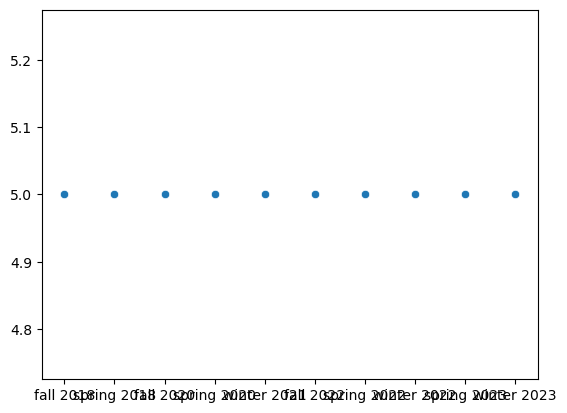

In [119]:
#sns.scatterplot(x=df.iloc[120]['years_taught'], y=df.iloc[120]['salaries'])
sns.scatterplot(x=df.iloc[150]['semester'], y=df.iloc[150]['average_rating'])